<div style="text-align: center; font-size:200%"> Tutorial: Analysis of the Roles of Classes </div>
<br>
<div style="text-align: center; font-size:200%"> Using These Cool Python Datascience Techniques! </div>
<br>
<div style="text-align: center; font-size:200%"> CMSC 320 </div>
<br>
<div style="text-align: center; font-size:200%"> Michael Suehle and Nathan Valencia </div>

# Introduction
With the end of the <a href="https://playvalorant.com/en-us/news/esports/announcing-the-2021-valorant-champions-tour/">first international Valorant competitive event</a> finally coming to a close and with there being several different highlight moments that will define the scene for many years to come, there are a lot of things that can be digested from a statistician’s point of view.  When looking at a top down view of a game, one would see that there are a lot of intricacies to team play including compositions, shotcalling, memorizing a team’s gameplan, individual explosive moments, utility combinations, divisions of members, and so much more.  But moreso, what makes this game more interesting are the unique characters and their utility sets. So what puts these characters in these respective classes? How should they perform in certain situations? And how do the top players who take these agents and make them their own perform at the highest level with each of them?  These are the questions we will be looking at when discussing this topic and using the data from the <a href="https://www.vlr.gg/stats">vlr website</a>.  There are a lot more things to come up from a player than just kills, so let us bring into the limelight the kinds of things that people should be more aware of when discussing this game and its agents.
<br> <br>
The first up are Sentinels.  These are the people that are expected to lockdown avenues and sites as well as expected to watch flanks so the team can focus on their main objectives.  They aren’t looked at to get a lot of kills and are mainly looked to for helping set up the rest of the team.  The next role would be the controllers.  These kinds of characters control the area that is being fought over by placing smokes in key areas to slow the aggression of the enemy team and allow the rest of the team to move safely from destination to destination.  These types of players are also not expected to get many kills and are reasonably used to help control areas and stay alive to keep controlling places that need presence.  Initiators are known for their information gathering skills.  They are said to “initiate” the fight by scanning areas, flashing out corners, de-buffing the enemy team, scouting portions of the map and in general being the first sets of util that set up an execute of a plan.  These people focus on their initial usage of utility but can also get kills.  As such, they are seen as the second fraggers behind the main stars of the show.  And those would be the duelists.  Duelists’ main job is to secure map control through the elimination of the opposing team.  They are the first bodies to take fights and should always be the first out of main chokes and areas.  They are equipped with utility to help themselves secure kills as well as push up deeper into enemy territory and hold aggressive angles.  The team helps set them up to succeed in getting into positions to get those kills, but the actual act of dispatching the enemy is normally done by this role.

# The Data
The first thing that we need to do is grab usable information and data to help support our arguments and findings.  The best place to do this is <a href="https://www.vlr.gg/stats">vlr.gg</a>.  This is an unofficial website that keeps tracks of several different things that happen in game for each player on their main agents.   However, there is a main statline of what this website keeps tracks of and that is how good a person can shoot at another person without dying.  But, this does not mean that the stats can't tell the story of each person's role.  The main stats that are kept on this website are as follows: kd, acs, adr, kpr, apr, fkpr, fdpr, hs%, cl%. Each of which will be discussed below: <br>
KD: Kills / Death<br>
ACS: Average Combat Score (Kills (point distribution by how many people are left) + Multikills (Additional 50 points for each kill after 1) + total damage).  Then it is averaged for each round at the end of the game<br>
ADR: Damage / Round<br>
KPR: Kills / Round<br>
APR: Assists / Round<br>
FKPR: First kill / Round<br>
FDPR: First Death / Round<br>
HS%: Headshot Kills / Kill<br>
CL%: Clutches / rounds in ‘x’ vs 1 situation<br>
<br>
These stats will help gather a better outline of the players and their agents and how they perform in their respective classes. 

## Data Collection and Wrangling
Here we are going to collect and store the data we need in separate dataframes for each character. We do this so that we can analze differences between classes more easliy. First, scrape the website for the table we need using <a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/">BeautifulSoup</a> and store in a <a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html#user-guide">pandas dataframe</a>. Next, we make a few adjustments to the data to better organize it. These adjustments include adding 0% in to the 'CL%' column where there are missing values, filling in the agent names in the 'Agent' column, adding a 'Class' column, and separating the player name and team name into separate columns. We used the specific sample of the  <a href="https://liquipedia.net/valorant/VCT/2022/Stage_1/Masters">first international Reykjavik</a> because it gives the broadest scope of players from different regions and their approaches to each of the agents/roles.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

#now im gonna try doing the same stuff above but for each character
agent_classes = {'phoenix':'duelist',
           'jett':'duelist',
           'viper':'controller',
           'sova':'initiator',
           'cypher':'sentinel',
           'brimstone':'controller',
           'sage':'sentinel',
           'omen':'controller',
           'raze':'duelist',
           'breach':'initiator',
           'astra':'controller',
           'chamber':'sentinel',
           'kayo':'initiator',
           'killjoy':'sentinel',
           'neon':'duelist',
           'reyna':'duelist',
           'skye':'initiator',
           'yoru':'duelist'}

all_agents = list(agent_classes.keys())


agent_data = dict()

for agent in all_agents:
    #Scrape the data from vlr.gg
    table_string = 'https://www.vlr.gg/stats/?event_group_id=all&event_id=926&series_id=all&region=all&country=all&min_rounds=1&min_rating=0&agent='+agent+'&map_id=all&timespan=90d'
    request = requests.get(table_string) 
    root = BeautifulSoup(request.content, 'html.parser')
    table = root.find('table')
    agent_frame = pd.read_html(str(table))[0]
    
    #change NaN in CL% to 0
    agent_frame['CL%'] = agent_frame['CL%'].replace(np.nan, '0%')
    
    #fill in agent name
    agent_frame['Agents'] = agent_frame['Agents'].replace(np.nan, agent)
    
    #add class
    class_col = [agent_classes[agent] for i in range(0,len(agent_frame))]
    agent_frame['Class'] = class_col
    
    #add team column
    teams = []
    names = []
    for i, row in agent_frame.iterrows():
        name_team = row['Player'].split(' ')
        names.append(name_team[0])
        if len(name_team) > 1:
            teams.append(name_team[1])
        else:
            teams.append('')

    agent_frame.drop(columns=['Player'])
    agent_frame['Player'] = names
    agent_frame['team'] = teams
    
    agent_data[agent]=agent_frame


Now let's see if the scraping and wrangling worked for the character Breach.

In [2]:
agent_data['breach'].head()

,Player,Agents,Rnd,ACS,K:D,KAST,ADR,KPR,APR,FKPR,...,CL%,CL,KMax,K,D,A,FK,FD,Class,team
0,JonahP,breach,43,228.5,1.09,81%,143.8,0.86,0.14,0.12,...,0%,0/3,25,37,34,6,5,2,initiator,TGRD
1,Crws,breach,61,202.7,0.91,67%,134.8,0.69,0.20,0.07,...,22%,2/9,18,42,46,12,4,4,initiator,XIA
2,Jamppi,breach,111,194.8,1.07,69%,124.6,0.71,0.11,0.12,...,10%,1/10,19,79,74,12,13,8,initiator,TL
3,Boaster,breach,20,169.0,0.71,60%,113.1,0.60,0.25,0.05,...,0%,0/2,12,12,17,5,1,2,initiator,FNC
4,Klaus,breach,18,169.0,0.71,67%,109.1,0.56,0.11,0.00,...,0%,0/2,10,10,14,2,0,0,initiator,KRÜ


For our analysis, we are going to combine the agent dataframes, but feel free to do agent-based exploratory analysis using the data scraping and wrangling methods we used above!

In [3]:
combined_data = pd.DataFrame()

# Iterate through each agent dataframe and add it to the combined dataframe
for agent in all_agents:
    agent_frame = agent_data[agent]
    combined_data = pd.concat([combined_data,agent_frame])


# Data Processing and Analysis
### Frequency and ACS of the Different Classes
To create the plots for our analysis, we use the <a href="https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.html">pyplot module of matplotlib</a>.
First, let's start by looking at the overall frequency and average combat scores (ACS) for each class. The code below creates two histograms that conveys this information.

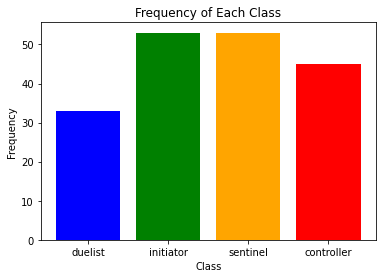

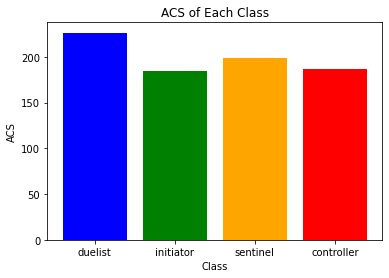

In [4]:
import matplotlib.pyplot as plt

class_colors = {'duelist':'blue', 'initiator':'green', 'sentinel':'orange', 'controller':'red'}
classes_acs = {'duelist':0,'initiator':0,'sentinel':0,'controller':0}
classes_freq = {'duelist':0,'initiator':0,'sentinel':0,'controller':0}

# Iterate through the rows and extrace the ACS
for i, row in combined_data.iterrows():
    classes = row['Class']
    classes_acs[classes] += row['ACS']
    classes_freq[classes] += 1
        
for key in classes_acs.keys():
    classes_acs[key] = classes_acs[key] / classes_freq[key]

# Plot the Frequencies of each class
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Class')
plt.bar(classes_acs.keys(), classes_freq.values(), color=class_colors.values())
plt.show()

# Plot the ACS of each class
plt.xlabel('Class')
plt.ylabel('ACS')
plt.title('ACS of Each Class')
plt.bar(classes_acs.keys(), classes_acs.values(), color=class_colors.values())
plt.show()

The main thing to grab from the frequency and ACS of each class is that there is fairly equal representation among all the classes. No specific class seems to be favored over the other, other than there being slightly less duelists and slightly more intiators, sentinels, and controllers.  However, we can already see the effects of the duelist role in the way that despite lower representation, their average ACS is higher than that of their counterparts.

### The Relationships Between ACS and K:D, FKPR, and APR
Now, let's look at the relationships between ACS and K:D, FKPR, and APR. This may lead to some insight on the performances between classes. The trends we notice in these plots will motivate how we go about creating models.

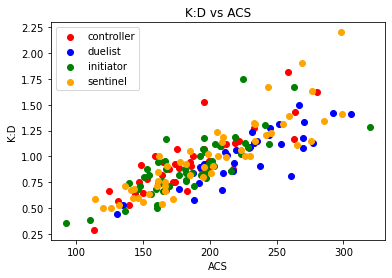

In [15]:
plt.figure()
class_colors = {'duelist':'blue', 'initiator':'green', 'sentinel':'orange', 'controller':'red'}

# Iterate through the classes and graph the relevant information
for i, class_data in combined_data.groupby(['Class']):
    kd = class_data['K:D']
    acs = class_data['ACS']
    plt.scatter(acs, kd, c=class_colors[class_data.iloc[0]['Class']], label=class_data.iloc[0]['Class'])

        
plt.title('K:D vs ACS')
plt.xlabel('ACS')
plt.ylabel('K:D')
plt.legend()

plt.show()

The trajectory for this graph seems fairly linear and this makes sense.  If a person is getting a lot more kills than deaths, then their ACS will definitely be higher.  One thing to note, however, is that the duelists seem to favor their ACS over their KD with the rest of the group trending higher in kd rather than ACS with a few outliers.  This could be attested to the fact that the duelists are maintaining a greater initial presence and getting the first couple kills, which net them the most points, and then the rest of the team cleans up after trading them out for map space and positioning where they can exit without dying.  The better duelists, and especially the better teams will have high acs duelists with high kd utility roles.
<br>
<br>
Now, similarly to how we plotted K:D vs ACS, we plot FKPR vs ACS.

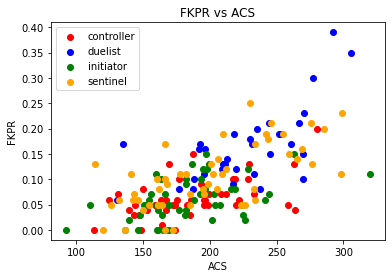

In [16]:
plt.figure()
    
# Iterate through the classes and graph the relevant information
for i, class_data in combined_data.groupby(['Class']):
    fkpr = class_data['FKPR']
    acs = class_data['ACS']
    plt.scatter(acs, fkpr, c=class_colors[class_data.iloc[0]['Class']], label=class_data.iloc[0]['Class'])

        
plt.title('FKPR vs ACS')
plt.xlabel('ACS')
plt.ylabel('FKPR')
plt.legend()

plt.show()

The FKPR vs ACS is also fairly linear, but there appears to be some variation between classes. What is shown here are how the first lines of defense and offense mingle with each other.  The top most of first kills and high ACS are dominated by the presence of duelists and sentinels.  This is regularly how an interaction is supposed to go and of course, if set up correctly, the duelists should win out more, which they do as seen.  However, the fact that sentinels are still highly present in those first kills shows how much their utility and site control is imperative to what makes a good player in that role and in those interactions.
<br>
<br>
Finally, let's look at APR vs ACS.

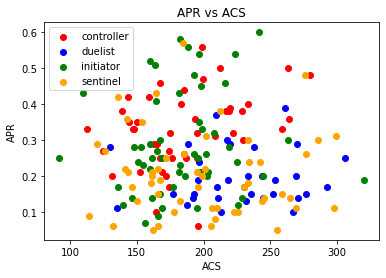

In [17]:
plt.figure()
    
# Iterate through the classes and graph the relevant information
for i, class_data in combined_data.groupby(['Class']):
    apr = class_data['APR']
    acs = class_data['ACS']
    plt.scatter(acs, apr, c=class_colors[class_data.iloc[0]['Class']], label=class_data.iloc[0]['Class'])

        
plt.title('APR vs ACS')
plt.xlabel('ACS')
plt.ylabel('APR')
plt.legend()

plt.show()

From this graph, there appears to be almost zero correlation between assists and ACS.  This is of course because damage and utility usage are not accounted for in the ACS calculation.  However, this still does show what the focus of the roles are and what can make a good player.  The lower portion of the graph is dominated by the duelists.  They of course go in for all the kills and do not provide as much assistance.  However, the top portion of the graph is primarily focused from the controllers and initiators.  So, a good indication that a person in these roles would be a high assistance rate in general.  ACS could be a good factor just to show a person can frag, but the overall usage of utility and assistance provides a better scope for this player and what they can add to a fight.
<br>
<br>
### FKPR and FDPR
Now that we've gained an idea about the relationships between ACS, classes, and K:D, FKPR, and APR, let's look at one more set of variables: FKPR and FDPR. This set of variables should give us more insight on the roles of each class.

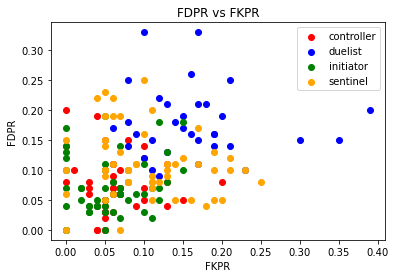

In [19]:
plt.figure()
    
# Iterate through the classes and graph the relevant information
for i, class_data in combined_data.groupby(['Class']):
    fdpr = class_data['FDPR']
    fkpr = class_data['FKPR']
    plt.scatter(fkpr, fdpr, c=class_colors[class_data.iloc[0]['Class']], label=class_data.iloc[0]['Class'])

        
plt.title('FDPR vs FKPR')
plt.xlabel('FKPR')
plt.ylabel('FDPR')
plt.legend()

plt.show()

This graph better displays the interactions between offense and defense and the roles of the different classes. In particular, it shows the setup difference between the two sides.  Since the duelists get a lot more team setup than an individual sentinel, the duelists will get a lot more return in their executes with more kills, but then traded out just as fast.  The sentinels get their own support, and first line of defense, so it is seen here as almost a reflection of the duelist role just in a slightly lower position due to their kit mainly placing emphasis on restricting access than overall damage.  Again, the initiators and controllers set up way behind both of these two roles and as such their first kills and deaths are a lot lower since they are helping either side setup to attack or defend rather than go in themselves. As such, a good player for duelists and sentinels would be able to get the first kill and not be the first death in a team fight.  More importantly though, what makes a good controller or initiator is still being able to provide utility usage while maybe attaining the first kill in a weird off position that catches the opponents off guard.  As such this would throw a team off.

## Predictions and Hypothesis Testing
In this section, we are going to create Linear Regression and KNN models for making predictions from our data. For the following hypothesis tests, we will use an alpha value of 0.05.
### Linear Regression with ACS
In this section we will use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">LinearRegression module from sklearn</a> and the <a href="https://www.statsmodels.org/stable/api.html">api module from statsmodels</a> to create two linear regression models: one simple linear regression for predicting K:D from ACS and one regression model with interaction terms to predict FKPR from ACS and Class. Note that each observation is independent of eachother so this satisfies that requirement for linear regression. We chose to do simple linear regression for predicting K:D because the scatter plot for K:D vs ACS tends to have the observations from each class mixed together. Whereas, we chose to add interaction terms to the regression model for predicting FKPR because the observations from each class tend to deviate more.
<br>
<br>
First, let's calculate and plot the linear regression model for predicting K:D from ACS. For this analysis, our null hypothesis is that there is not relationship between K:D and ACS. Our alternate hypothesis is that there is a relationship!

                            OLS Regression Results                            
Dep. Variable:                    K:D   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     391.4
Date:                Mon, 16 May 2022   Prob (F-statistic):           3.19e-47
Time:                        01:31:10   Log-Likelihood:                 64.313
No. Observations:                 184   AIC:                            -124.6
Df Residuals:                     182   BIC:                            -118.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1619      0.058     -2.807      0.0

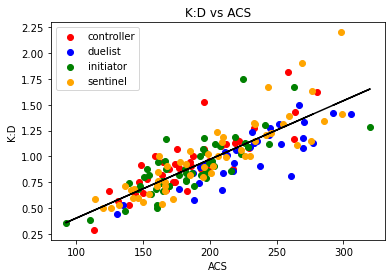

In [21]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Identify our independent (y) and dependent (X) variables and compute the model
X = combined_data['ACS']
y = combined_data['K:D']
X2 = sm.add_constant(X)
reg = sm.OLS(y, X2).fit()

print(reg.summary())

# Plot the regression line
plt.figure()
plt.plot(X, reg.predict([[1,i] for i in X]), color='black') 

# Below is the same code for making the scatter plot from before
for i, class_data in combined_data.groupby(['Class']):
    kd = class_data['K:D']
    acs = class_data['ACS']
    plt.scatter(acs, kd, c=class_colors[class_data.iloc[0]['Class']], label=class_data.iloc[0]['Class'])

        
plt.title('K:D vs ACS')
plt.xlabel('ACS')
plt.ylabel('K:D')
plt.legend()

plt.show()

There are a few important statistical measurements to note from the model. First is the R-Square value. This R-Square value of 0.683 signifies that around 68.3% of variation in K:D can be attributed to variation in ACS. This implies that there is a fairly strong correlation between K:D and ACS as the coefficient of correlation, R, would be 0.829. Another statistical measurement to note is the p>|t| value for 'const' and 'ACS'. These values are the p-value for the y-intercept and slope of our regression line. Since both values of 0.006 and 0.000 are less than our alpha of 0.05, both the y-intercept and slope of this model are statistically significant. So we can reject the null hypothesis!
<br>
<br>
Before we can use this model, there is one more statistical measure we should check: the distribution of the residuals.

Text(0, 0.5, 'Frequency')

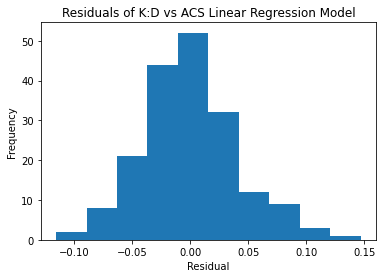

In [34]:
plt.hist(reg.resid)
plt.title('Residuals of K:D vs ACS Linear Regression Model')
plt.xlabel('Residual')
plt.ylabel('Frequency')

The residuals appear to have a realatively normal distribution with a mean of 0, so based on this and our R-Square and p-values, we can say that this model is fairly reliable.
<br>
<br>
Now, let's look at a regression model that predicts FKPR from ACS and Class. This model will need to include interaction terms for each of the classes, so below we use <a href="https://www.statsmodels.org/stable/api.html">statsmodel.formula.api</a> along with dummy columns to easily acheive this. For this analysis, our null hypothesis is that there is not relationship between FKPR, Classes, and ACS. Our alternate hypothesis is that there is a relationship!

In [23]:
import statsmodels.formula.api as smf

combined_data_dummies = pd.get_dummies(combined_data, columns=['Class'])

reg = smf.ols(formula='FKPR ~ Class_duelist + Class_initiator + Class_sentinel + Class_controller + ACS*Class_duelist + ACS*Class_initiator + ACS*Class_sentinel + ACS*Class_controller', data=combined_data_dummies).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                   FKPR   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     35.94
Date:                Mon, 16 May 2022   Prob (F-statistic):           7.44e-31
Time:                        01:49:45   Log-Likelihood:                 320.49
No. Observations:                 184   AIC:                            -625.0
Df Residuals:                     176   BIC:                            -599.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0498 

As with the last model, we need to look at the R-Square value and the p-values. The R-Square value of 0.588 indicates that around 58.8% of variation in FKPR can be attributed to variation in ACS. This also indicates a fairly strong correlation, corresponding to a correlation coefficient of 0.767. The p-values indicate that the intercept terms for class as well as the slope terms for each class, excluding duelist, are not statistically significant, whereas the remaining terms are statistically significant. This means that the only interaction term that makes a significant difference in this model is the one for the duelist class and this is reflected in the scatter plot FKPR vs ACS as the duelist observations tend to deviate more from the others classes. So we can reject the part of the null hypthesis saying that there is not relationship between FKPR and ACS and there there is no relationship between the duelist class and the relationship between FKPR and ACS. We however cannot reject the part of the null hypothesis that states there is no relationship between the other classes and the relationship between FKPR and ACS.

Text(0, 0.5, 'Frequency')

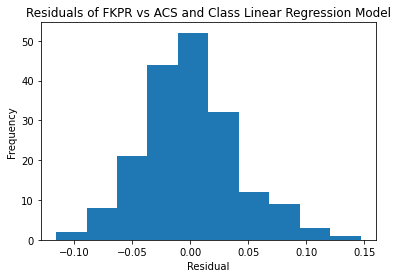

In [35]:
plt.hist(reg.resid)
plt.title('Residuals of FKPR vs ACS and Class Linear Regression Model')
plt.xlabel('Residual')
plt.ylabel('Frequency')

Finally, the residuals for this model have a relatively normal distribution with a mean of 0, so these with the R-Square value and the p-values indicate that this model is reliable.

### KNN Predicting Class from FKPR and FDPR
Now let's use K-Nearest Neighbors to predict Classes from FKPR and FDPR. Here we will use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">KNeighborsClassifier</a>, <a href="https://scikit-learn.org/stable/model_selection.html">model selection</a>, and <a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics">metrics</a> modules from sklearn along with the <a href="https://docs.scipy.org/doc/scipy/reference/stats.html">stats</a> module from scipy to create, train, and evaluate our KNN model. We also use the <a href="http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/">plot_decision_regions</a> function from mlxtend.plotting to plot a visualization of out KNN model. We decided to evaluate the KNN model useing 10-folds cross validation since we are using a relatively small dataset. Feel free to try out different crossvalidation methods! For our evaluation, we decided to calculate the accuracies for identifying each type of class since the KNN model appears to be better at predicting some classes than others.

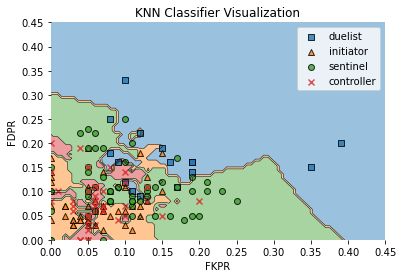

Average Accuracy for duelist: 0.6837789661319075
Average Accuracy for initiator: 0.29047619047619044
Average Accuracy for sentinel: 0.5303981732553161
Average Accuracy for controller: 0.07291666666666667


In [32]:
from sklearn import datasets, neighbors
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection as ms
import sklearn.metrics as met
from scipy import stats
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap

# We tried a few different values for k and decided that 4 resulted in the best accuracy.
# Feel free to try out this code with different values for k!
kneigh = KNeighborsClassifier(n_neighbors=4) 

# Some dictionaries to help with mapping
cmap_light = ListedColormap(['lightblue', 'lightgreen', 'lightorange', 'lightred'])
cmap_bold = ['darkblue', 'darkgreen', 'darkorange', 'darkred']
class_codes = {'duelist':0, 'initiator':1, 'sentinel':2, 'controller':3}
knn_accuracies = {'duelist':[], 'initiator':[], 'sentinel':[], 'controller':[]}

# Set up the 10 Folds
kf = ms.KFold(n_splits=10)

# Set up the independent and dependent variables
ind = pd.DataFrame(combined_data[['FKPR','FDPR','Class']])
dep = np.array([class_codes[i] for i in combined_data['Class']])
first = True

for train_index, test_index in kf.split(ind):
    # Divide training and testing data base on the fold
    ind_train = ind.iloc[train_index].drop(columns='Class')

    ind_test = {'duelist':ind.iloc[test_index][ind.iloc[test_index]['Class']=='duelist'], 
                'initiator':ind.iloc[test_index][ind.iloc[test_index]['Class']=='initiator'], 
                'sentinel':ind.iloc[test_index][ind.iloc[test_index]['Class']=='sentinel'],
                'controller':ind.iloc[test_index][ind.iloc[test_index]['Class']=='controller']}
    dep_train= dep[train_index]
    dep_test = dep[test_index]
    
    # Fit and test model
    clf = kneigh.fit(ind_train, dep_train)
    
    for classes in class_codes.keys():
        ind_test[classes] = ind_test[classes].drop(columns='Class').dropna()
        
        if len(ind_test[classes]) > 0:
            dep_pred = clf.predict(ind_test[classes])
            dep_test = [class_codes[classes]]*len(dep_pred)
    
            # Store the accuracies
            knn_accuracies[classes].append(met.accuracy_score(dep_test, dep_pred))
    
    # Here we only plot one of the visualizations of the model, but you can take this check out
    # and see what the other plots for different iterations of the cross validation look like.
    if first:
        # Plot the visualization
        ax = plot_decision_regions(ind_train.to_numpy(), dep_train, clf=clf, legend=2)
        # Adding axes annotations
        plt.xlabel('FKPR')
        plt.ylabel('FDPR')
        plt.title('KNN Classifier Visualization')
        plt.xlim([0,0.45])
        plt.ylim([0,0.45])
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['duelist', 'initiator', 'sentinel', 'controller'])
        plt.show()
        first = False

for classes in knn_accuracies.keys():
    print("Average Accuracy for "+classes+": " + str(sum(knn_accuracies[classes])/len(knn_accuracies[classes]))) #print average accuracy of the 10 folds

Overall, this model does not have the very good performance. It can predict duelists with an accuracy of 68.38% and sentinels with an accuracy of 53.04%, but it is very poor at predicting initiators and controllers with accuracies of 29.05% and 7.29% respectively. This is likely due to the fact that duelists tend to dominate the upper right portion of the scatter plot and sentinels tend to dominate the middle. The controllers and initiators both dominate the lower left portion and, as a result, KNN has trouble distinguishing between the two.

# Conclusion/Takeaways
From these findings, we can basically take away that the game is split into two different interactions.  The set pieces between the sentinels and duelists, and then how well can the controllers and intitiators back them up.  We saw that through the likes of FKPR vs ACS and FKPR vs FDPR that these major scenes in a round can make or break a match for either team.  So the stand out stats that outline a role and how they perform at their peaks are as follows - 
<br><br>
Duelists: the ability to enter and get multiple kills before eventually getting traded. Thus having a high ACS and FKPR is essential.
<br>
Sentinels: the ability to stop the duelists from being enabled and being able to get at least one kill and staying alive until utility can help you.  This can be seen in high FKPR and lower FDPR relative to duelists.
<br>
Controllers: the ability to smoke quickly and effectively before entering alongside a duelist and hopefully live to the end. This is evident in the FDPR, and higher average ACS comparable to traditional sentinels and initiators (individual research into one of the sentinels, Chamber, revealed that his utility played more into holding sites through killing with different weapons rather than stalling with tripwires or alarm robots thus bolstering the average sentinel killing ability a bit).
<br>
Initiators: the ability to enable your duelist through effective utility.  This was shown in FDPR and APR.
<br><br>
Some further research could be analyzing performance by agent or repeating this analysis with data from different competitions. You could also look into alternate prediting models such as decision trees and K-means clustering.